In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from pandas import read_csv, Series
import numpy as np
import scipy
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
def clean_and_read_adult(data_file="train"):
    try:
        f = open('adult_%s.csv' % data_file)
    except IOError:
        f = open('adult.%s' % data_file)
    lines = f.read().split('\n')
    w = open('adult_%s_clean.csv' % data_file, 'wb')
    w.write(lines[0]+'\n')
    for l in lines[1:]:
        w.write(','.join([_.strip() for _ in l.split(',')])+'\n')
    w.close()
    f.close()
    data = read_csv('adult_%s_clean.csv' % data_file)
    return data

In [3]:
data_train = clean_and_read_adult('train')
data_test = clean_and_read_adult('test')

total_train = len(data_train)
total_test = len(data_test)

In [4]:
data_test.columns

Index([u'age', u'workclass', u'fnlwgt', u'education', u'education-num',
       u'marital-status', u'occupation', u'relationship', u'race', u'sex',
       u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country',
       u'salary'],
      dtype='object')

In [5]:
race_label_encoder = LabelEncoder()

race_labels = race_label_encoder.fit(data_train['race'])

In [6]:
race_labels.classes_

array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
       'White'], dtype=object)

In [7]:
target_race = 'White'

In [8]:
data_train['class'] = Series(data_train['race'] == target_race)
data_test['class'] = Series(data_test['race'] == target_race)

In [9]:
def show_race_occupation(query_ethic='White'):
    data_ethic = data_train[data_train['race'] == query_ethic]
    data_ethic['occupation'].hist(label=query_ethic)

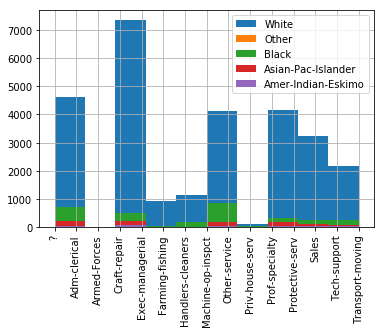

In [10]:
for race in race_labels.classes_[::-1]:
    show_race_occupation(race)
plt.xticks(rotation=90)
plt.legend()

In [11]:
for race in race_label_encoder.classes_:
    print race, np.bincount(data_train[data_train['occupation'] == 'Exec-managerial']['race'] == race)

Amer-Indian-Eskimo [4036   30]
Asian-Pac-Islander [3931  135]
Black [3822  244]
Other [4055   11]
White [ 420 3646]


In [12]:
np.bincount(data_train['occupation'] == 'Exec-managerial')

array([28495,  4066])

In [13]:
for race in race_label_encoder.classes_:
    print race, np.bincount(data_train[data_train['race'] == race]['occupation'] == 'Armed-Forces')

Amer-Indian-Eskimo [310   1]
Asian-Pac-Islander [1039]
Black [3123    1]
Other [271]
White [27809     7]


In [14]:
X = data_train.values
pop_skew = []
for i in range(X.shape[1]):
    try:
        pop_skew.append(scipy.stats.skew(X[:,i]))
    except TypeError:
        continue

/Users/sivaramanks/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [15]:
X = data_train[data_train['race'] == 'White'].values
white_skew = []
for i in range(X.shape[1]):
    try:
        white_skew.append(scipy.stats.skew(X[:,i]))
    except TypeError:
        continue

In [16]:
X = data_train[data_train['race'] == 'Black'].values
black_skew = []
for i in range(X.shape[1]):
    try:
        black_skew.append(scipy.stats.skew(X[:,i]))
    except TypeError:
        continue

In [17]:
condition1 = data_train['race'] == 'Black'
condition2 = data_train['occupation'] == 'Exec-managerial'

X = data_train[condition1 & condition2].values
black_mgr_skew = []
for i in range(X.shape[1]):
    try:
        black_mgr_skew.append(scipy.stats.skew(X[:,i]))
    except TypeError:
        continue
        
condition1 = data_train['race'] == 'White'
condition2 = data_train['occupation'] == 'Exec-managerial'

X = data_train[condition1 & condition2].values
columns = data_train.columns
numeric_labels = []
white_mgr_skew = []
for i in range(X.shape[1]):
    try:
        white_mgr_skew.append(scipy.stats.skew(X[:,i]))
        numeric_labels.append(columns[i])
    except TypeError:
        continue

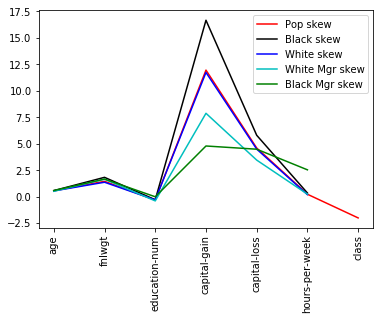

In [18]:
plt.plot(pop_skew, 'r', label="Pop skew")
plt.plot(black_skew, 'k', label="Black skew")
plt.plot(white_skew, 'b', label="White skew")
plt.plot(white_mgr_skew, 'c', label="White Mgr skew")
plt.plot(black_mgr_skew, 'g', label="Black Mgr skew")
plt.legend()
plt.xticks(range(len(numeric_labels)), numeric_labels, rotation='vertical')
plt.show()

In [19]:
model_rf = RF(n_estimators=100, n_jobs=-1)

In [20]:
print 'all', np.bincount(data_train['class'])
for race in data_train['race'].unique():
    query_race = data_train['race'] == race
    class_race = data_train[query_race]['class']
    print race, np.bincount(class_race)

all [ 4745 27816]
White [    0 27816]
Black [3124]
Asian-Pac-Islander [1039]
Amer-Indian-Eskimo [311]
Other [271]


In [21]:
def get_distribution(distr_sample):
    values = np.bincount(distr_sample)
    total = float(len(distr_sample))
    return values/total

In [22]:
#X_train = data_train.fillna(0).loc[:, data_train.columns != 'salary']
# set missing values to 0
#X[X == '?'] = 0
X_train = data_train.loc[:, data_train.columns != 'class'].values
Y_train = data_train['class'].values

In [23]:
X_train.shape, Y_train.shape

((32561, 15), (32561,))

In [24]:
# encode string input values as integers
def transform_train(X):
    label_attributes = {}
    encoded_x = None
    numeric_x = None
    for i in range(0, X.shape[1]):
        if type(X[0,i]) != str:
            if numeric_x is None:
                numeric_x = X[:,i].reshape(X.shape[0], 1)
                print numeric_x.shape

            else:
                numeric_x = np.concatenate((X[:,i].reshape(X.shape[0], 1), numeric_x), axis=1)
            continue
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(X[:,i])
        feature = feature.reshape(X.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False)
        feature = onehot_encoder.fit_transform(feature)
        label_attributes[i] = {'label_encoder': label_encoder, 'onehot_encoder': onehot_encoder}
        if encoded_x is None:
            encoded_x = feature
        else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
    print("encoded X shape: : ", encoded_x.shape)
    print("numericX shape: : ", numeric_x.shape)
    X_ = np.concatenate((numeric_x, encoded_x), axis=1)
    print("Final Shape:", X_.shape)
    return X_, label_attributes

def transform_test(X, label_attributes):
    encoded_x = None
    numeric_x = None
    for i in range(0, X.shape[1]):
        if type(X[0,i]) != str:
            if numeric_x is None:
                numeric_x = X[:,i].reshape(X.shape[0], 1)
                print numeric_x.shape

            else:
                numeric_x = np.concatenate((X[:,i].reshape(X.shape[0], 1), numeric_x), axis=1)
            continue
        label_encoder = label_attributes[i]['label_encoder']
        feature = label_encoder.transform(X[:,i])
        feature = feature.reshape(X.shape[0], 1)
        onehot_encoder = label_attributes[i]['onehot_encoder']
        feature = onehot_encoder.transform(feature)
        if encoded_x is None:
            encoded_x = feature
        else:
            encoded_x = np.concatenate((encoded_x, feature), axis=1)
    print("encoded X shape: : ", encoded_x.shape)
    print("numericX shape: : ", numeric_x.shape)
    X_ = np.concatenate((numeric_x, encoded_x), axis=1)
    print("Final Shape:", X_.shape)
    return X_

In [25]:
#X_test = data_test.fillna(0).loc[:, data_test.columns != 'salary']
# set missing values to 0
#X[X == '?'] = 0
X_test = data_test.loc[:, data_test.columns != 'class'].values
Y_test = data_test['class'].values
X_test.shape

(16281, 15)

In [26]:
limit = len(X_train)
X_combined, _ = transform_train(np.concatenate((X_train, X_test), axis=0))

X_train_transformed, X_test_transformed = X_combined[:limit],X_combined[limit:]

print X_train_transformed.shape, X_test_transformed.shape

(48842, 1)
('encoded X shape: : ', (48842, 106))
('numericX shape: : ', (48842, 6))
('Final Shape:', (48842, 112))
(32561, 112) (16281, 112)


In [27]:
model_rf = RF(n_estimators=100)

In [28]:
model_rf.fit(X_train_transformed,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
pred_rf = model_rf.predict(X_train_transformed)

In [30]:
np.bincount(pred_rf == Y_train)

array([    0, 32561])

In [31]:
pred_rf_test = model_rf.predict(X_test_transformed)

In [32]:
np.bincount(pred_rf_test == Y_test)

array([    0, 16281])

In [33]:
## after deskewing it

In [34]:
##races_prior = {'all': {'no': class_no_prior, 'yes':class_yes_prior}}
occupation_prior = {}
for occupation in data_train['occupation'].unique():
    data = data_train[data_train['occupation'] == occupation]
    occupation_prior[occupation] = {}
    for race in [target_race]:
        values = get_distribution(data['race']==race)
        if len(values) == 1:
            no = 1.
            yes = 0.
        else:
            no, yes = values
        occupation_prior[occupation] = {'no_prior': no, 'yes_prior': yes}

In [35]:
## Correlates directly with skew values
import pprint
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(occupation_prior)

{   '?': {   'no_prior': 0.17797069994574063, 'yes_prior': 0.82202930005425934},
    'Adm-clerical': {   'no_prior': 0.1819628647214854,
                        'yes_prior': 0.81803713527851463},
    'Armed-Forces': {   'no_prior': 0.22222222222222221,
                        'yes_prior': 0.77777777777777779},
    'Craft-repair': {   'no_prior': 0.098804586484508419,
                        'yes_prior': 0.90119541351549159},
    'Exec-managerial': {   'no_prior': 0.10329562223315297,
                           'yes_prior': 0.89670437776684697},
    'Farming-fishing': {   'no_prior': 0.079476861167002005,
                           'yes_prior': 0.92052313883299797},
    'Handlers-cleaners': {   'no_prior': 0.17226277372262774,
                             'yes_prior': 0.82773722627737223},
    'Machine-op-inspct': {   'no_prior': 0.1953046953046953,
                             'yes_prior': 0.8046953046953047},
    'Other-service': {   'no_prior': 0.23429438543247344,
                  

In [36]:
class_no_prior, class_yes_prior = get_distribution(data['race'] == 'Black')

In [37]:
all_no, all_yes = np.bincount(data_train['class'])
yes_over_no = all_yes/float(all_no)
no_over_yes = 1/yes_over_no

In [38]:
class_no_prior, class_yes_prior

(0.81208053691275173, 0.18791946308724833)

In [47]:
### Main Deskewing Routine

data = data_train
new_X = None
_sum = 0

races_prior = occupation_prior
for race in races_prior:
    if races_prior[race]['no_prior'] >= class_no_prior:
        race_yes_index = data.index[(data['occupation'] == race) & (data['class'] == True)].tolist()
        race_no_index = data.index[(data['occupation'] == race) & (data['class'] == False)].tolist()
        race_no_index = np.random.choice(race_no_index,
                                         int(no_over_yes*len(race_yes_index)), replace=False).tolist()
    else:
        race_no_index = data.index[(data['occupation'] == race) & (data['class'] == False)].tolist()
        race_yes_index = data.index[(data['occupation'] == race) & (data['class'] == True)]
        race_yes_index = np.random.choice(race_yes_index,
                                          int(yes_over_no*len(race_no_index))).tolist()
    print len(race_no_index)/ float(len(race_yes_index)+len(race_no_index))
    _sum += len(race_no_index + race_yes_index)
    ##print data.loc[race_no_index+race_yes_index,['race', 'class']]
    ##raw_input()
    if new_X is None:
        new_X = X_train_transformed[race_no_index + race_yes_index]
        new_Y = Y_train[race_no_index + race_yes_index]
    else:
        new_X = np.concatenate((new_X, X_train_transformed[race_no_index + race_yes_index]), axis=0)
        new_Y = np.concatenate((new_Y, Y_train[race_no_index + race_yes_index]), axis=0)
print total_train
print _sum

0.145756457565
0.153846153846
0.145735876214
0.145742873325
0.145756457565
0.145752608048
0.145730416373
0.145732130465
0.145768993206
0.145777777778
0.145740386658
0.145739910314
0.145758661888
0.145833333333
0.145732389117
32561
32556


In [48]:
new_X.shape

(32556, 112)

In [49]:
model_deskew = RF(n_estimators=100, n_jobs=-1)
model_deskew.fit(new_X, new_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [50]:
pred_rf_deskew = model_deskew.predict(X_train_transformed)

In [51]:
np.bincount(pred_rf_deskew == Y_train)

array([    0, 32561])

In [52]:
pred_rf_deskew_test = model_deskew.predict(X_test_transformed)

In [53]:
np.bincount(pred_rf_deskew_test == Y_test)

array([    0, 16281])